## CrowdED: Crowdsourcing task optimization
---
The research question we aim to answer is: "Can we a-priori estimate optimal workers and tasks' assignment to obtain maximum accuracy on all tasks?"

*This notebook takes step by step the construction of the crowdED module*

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---

### Tasks Generator Module

In our simulation, the task is that the worker has to choose one out of the five given answers. Here, we simulate the true answer for each worker-task pair.

It is needed one of the keys for the answer

In [2]:
import sys
import numpy as np
import pandas as pd
import shortuuid as uid
import crowded.key_words as kw

KEYS = 7
HARD = 0.3
LEN = 12
N = 10

class Tasks(object):
    def __init__(self, keys=KEYS, length=LEN):
        """
        :param keys: number of valid answers expected to be assessed
        :type keys: python list or numpy array of any stringable objects
        :param length: length of the identifier
        :type length: int
        """
        self.length = length
        self.keys = keys

    def _generate_tasks(self, n=N):
        """
        :param n: number of tasks to be generated (default value: 10)
        :type n: int
        """
        return ['task_' + uid.ShortUUID().random(length=self.length) for i in range(n)]

    def _random_words(self):
        return [i for i in np.random.choice(kw.words(), self.keys, replace=False)]

    def _true_answer(self, n=N):
        """
        :param n: number of true answers to be generated (default value: 10)
        :type n: int
        """
        return [answer for answer in np.random.choice(self._random_words(), n)]

    def create(self, n=N, h=HARD):
        """
        :param n: number of tasks to be generated (default value: 10)
        :type n: int
        :param h: proportion of hard tasks a priori selected for the experiment (default value: 0.2)
        :type h: float
        """
        e = 1 - h
        cut_tasks = 0.5
        tasks = self._generate_tasks(n)
        probs_tasks = []
        easy_tasks = [task for task in np.random.choice(
            tasks, int(round(e * n, 0)), replace=False)]
        hard_tasks = [task for task in set(tasks) - set(easy_tasks)]
        df = pd.DataFrame()
        df['task_id'] = tasks
        df['true_answers'] = self._true_answer(n)
        df['label_task'] = ['hard_task' if tasks[i]
                            in hard_tasks else 'easy_task' for i in range(n)]
        for i in df['label_task']:
            if i == 'easy_task':  # uniform from .75 to 1
                probs_tasks.append(np.random.choice(
                    (np.arange(cut_tasks, 1, 0.01)), 1))
            elif i == 'hard_task':  # uniform from .5 to .75
                probs_tasks.append(np.random.choice(
                    (np.arange(0.01, cut_tasks, 0.01)), 1))
            else:
                probs_tasks.append(1)

        df['prob_task'] = [item for prob in probs_tasks for item in prob]
        return df

### Tasks Generation Module

In [3]:
total_tasks = 415
p_hard_tasks = 0.4
number_of_valid_answers = 5

In [4]:
df_tasks = Tasks(number_of_valid_answers).create(total_tasks, p_hard_tasks)
df_tasks.head()

,task_id,true_answers,label_task,prob_task
0,task_mxAzDeWXz5Uj,folds,hard_task,0.20
1,task_kWDSN7DUo7wa,clicks,hard_task,0.20
2,task_jCVKkVboLJFb,folds,hard_task,0.44
3,task_aNFXhj9xCRTi,clicks,easy_task,0.96
4,task_sgB522bUqgoB,cruise,hard_task,0.42


### Workers and Distribution Module

In [5]:
import sys
import pandas as pd
import shortuuid as uid
from scipy.stats import beta

LEN = 12
N = 10
a = 28
b = 3

class Workers(object):
    def __init__(self, alpha=a, beta=b, length=LEN):
        """
        :param alpha: parameter alpha of a beta distribution (default value: 28)
        :type alpha: float
        :param beta: parameter beta of a beta distribution (default value: 3)
        :type beta: float
        :param length: number of workers to be created (default value:10)
        :type length: type
        """
        self.length = length
        self.alpha = alpha
        self.beta = beta

    def create(self, n=N):
        df = pd.DataFrame(
            {'worker_id': [uid.ShortUUID().random(self.length) for i in range(n)],
             'prob_worker': beta.rvs(self.alpha, self.beta, size=n)})
        return df

### Workers Generation

In [6]:
total_workers = 40

In [7]:
df_workers = Workers().create(total_workers)
df_workers.head()

,prob_worker,worker_id
0,0.895679,PoRxnxWCB2mc
1,0.902518,CLbPWMp9mu5g
2,0.969116,CoRnDJEjCw7K
3,0.920916,MZujWgeEEd6q
4,0.806406,32XsnBvPwHKw


---
In this step, we first calculate the exact probabilities of getting the answer right for each worker and each task.

Since the ability is unknown before the task is undertaken, we use a beta distribution to model the distribution of worker ability. Its probability density function $f(x|a, v)$ is given by 

$$
f(x|a,v) = Beta (\frac{a}{\min(a,1-a)v}, \frac{(1-a)}{\min(a,1-a)v})
$$

Here a ∈ (0, 1) is the normalized value of the average ability of the workers in the crowdsourcing platform.  
v ∈ (0, 1) is a parameter that determines the variance in worker ability  
[Paper](https://aaai.org/ocs/index.php/HCOMP/HCOMP16/paper/viewFile/14047/13632)  

Mean probability 0.9029813460673075


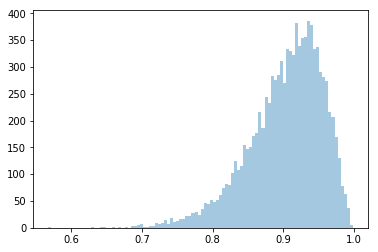

In [8]:
data_beta = beta.rvs(28, 3, size=10000)
sns.distplot(data_beta, kde=False, bins=100)
print('Mean probability {}'.format(np.mean(data_beta)))

In general we have good workers, on average the 90% of chances to getting the answer right

---

#### Summary of aggregated probabilities

In [9]:
df_tasks.groupby('label_task').agg(['mean','count'])

prob_task      
                mean count
label_task                
easy_task   0.734337   249
hard_task   0.249217   166

In [10]:
df_workers.describe()

,prob_worker
count,40.000000
mean,0.892749
std,0.059548
min,0.767366
25%,0.861885
50%,0.902979
75%,0.932875
max,0.981417


--- 

### Creating a task-worker assignation

this function has to eat btw the 2 df result from the previous functions

In [11]:
import pandas as pd
import numpy as np

WPT = 3

class AssignTasks(object):
    def __init__(self, tasks, workers, wpt=WPT):
        """
        :param tasks: table created usings Tasks().create() object
        :type tasks: pandas dataframe
        :param workers: table created using Workers().create object
        :type workers: pandas dataframe
        :param wpt: number of workers per task for the simulation
        "param type: integer
        """
        self.wpt = wpt
        self.tasks = tasks
        self.workers = workers

    def _worker_assign(self):
        if self.wpt > len(self.workers):
            raise Exception(
                'Number of workers per task must be smaller than the number of workers!')
        return [worker for i in [np.random.choice(self.workers.worker_id, self.wpt, replace=False) for task in self.tasks.task_id] for worker in i]

    def _task_asssign(self):
        if self.wpt % 2 == 0:
            raise Exception('Number of workers per task must be odd!')
        return [item for k in [[self.tasks.task_id[i]] * self.wpt for i in range(len(self.tasks.task_id))] for item in k]
    
    def create(self):
        df = pd.DataFrame({'task_id': self._task_asssign(),
                           'worker_id': self._worker_assign()})
        df = pd.merge(df, self.tasks, on='task_id', how='left')
        df = pd.merge(df, self.workers, on='worker_id', how='left')
        return df

In [12]:
wpt = 5 #workers per task always smaller than the number of workers

In [13]:
df_tw = AssignTasks(df_tasks, df_workers, wpt).create()
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker
0,task_mxAzDeWXz5Uj,XjGX2g7RbhqA,folds,hard_task,0.2,0.935943
1,task_mxAzDeWXz5Uj,2jXzD7cJ5QzA,folds,hard_task,0.2,0.892761
2,task_mxAzDeWXz5Uj,3QktdYBsaGAC,folds,hard_task,0.2,0.811139
3,task_mxAzDeWXz5Uj,AGfq8KnhEYxy,folds,hard_task,0.2,0.767366
4,task_mxAzDeWXz5Uj,nzh8TjaJVZ3Y,folds,hard_task,0.2,0.859198


In [14]:
#aggregation of the tasks
_agg = df_tw.groupby('worker_id').agg('count')['task_id']
_agg.name = 'tasks'
_agg.sort_values(ascending=False).head()

worker_id
CoRnDJEjCw7K    67
GZVwLxjcLXLK    67
tHCHrZveR7Zt    65
3QktdYBsaGAC    62
pTW3D953e786    62
Name: tasks, dtype: int64

---
### Probabilities of getting the answer right

w = worker answer correct  
T = Having knowledge to do the task


$$
P(w~|~T) = \frac{P(T~|~w) P(w)}{P(T~|~w) P(w) + P(T~|~w^c) P(w^c)}
$$

[Bayes for conditional probability example](http://www.stat.yale.edu/Courses/1997-98/101/condprob.htm)

Class propuse:  
Based on two vectors (pandas series same lenght) of probabilities create a conditional probability  
one vector for person, another for activity in this case workers and tasks
This new conditional prob is the prior probability for a Bernoulli likelihood  
Then the predicion will tell if the answer was right or not  

The Bernoulli is the posterior function to modelate the action

In [15]:
keys = df_tasks['true_answers'].unique()

In [16]:
keys

array(['folds', 'clicks', 'cruise', 'wrenches', 'tasks'], dtype=object)

In [17]:
import pandas as pd
from scipy.stats import bernoulli

class ComputeProbability(object):
    def __init__(self, series1, series2, keys, size=1):
        self.size = size
        self.series1 = series1
        self.series2 = series2
        self.keys = keys
        
    def _random_selection(self):
        return 1/len(self.keys)
    
    def _bayes_prob(self):
        if len(self.series1) != len(self.series2):
            raise Exception("Probability series expected to be the same size")
        return (self.series1 * self.series2) / (self.series1 * self.series2 + self._random_selection() * (1 - self.series2))
    
    def predict(self):
        return self._bayes_prob().apply(lambda prob: bernoulli.rvs(size=self.size, p=prob)[0])

In [18]:
cp = ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)

In [19]:
import numpy as np

class WorkerAnswer(object):
    def __init__(self, series1, series2, keys):
        """
        series1 = vector of true answers
        series2 = vector of 1 and 0
        key = vector of odd number of strings
        """
        self.series1 = series1
        self.series2 = series2
        self.keys = keys
    
    def match(self):
        answers = []
        for idx, i in enumerate(self.series2):
            if i == 1:
                answers.append(self.series1.loc[idx])
            else:
                answers.append(np.random.choice([i for i in set(self.keys)-set(self.series1.loc[idx])], 1)[0])

        return answers 

In [20]:
worker_answer = WorkerAnswer(df_tw['true_answers'], cp.predict(), keys)

In [21]:
df_tw['worker_answers'] = worker_answer.match()

In [22]:
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker,worker_answers
0,task_mxAzDeWXz5Uj,XjGX2g7RbhqA,folds,hard_task,0.2,0.935943,folds
1,task_mxAzDeWXz5Uj,2jXzD7cJ5QzA,folds,hard_task,0.2,0.892761,folds
2,task_mxAzDeWXz5Uj,3QktdYBsaGAC,folds,hard_task,0.2,0.811139,folds
3,task_mxAzDeWXz5Uj,AGfq8KnhEYxy,folds,hard_task,0.2,0.767366,clicks
4,task_mxAzDeWXz5Uj,nzh8TjaJVZ3Y,folds,hard_task,0.2,0.859198,folds


---
### Confusion Matrix for the answers

Based on [pycm](https://github.com/sepandhaghighi/pycm) analysis

In [23]:
from pycm import *

In [24]:
cm = ConfusionMatrix(df_tw['true_answers'].tolist(), df_tw['worker_answers'].tolist())

In [25]:
cm.matrix()

Predict          clicks   cruise   folds    tasks    wrenches 
Actual
clicks           371      3        5        7        4        
cruise           5        437      4        8        6        
folds            6        7        370      9        3        
tasks            1        4        3        345      7        
wrenches         2        8        7        8        445      



In [26]:
cm.Overall_ACC

0.948433734939759

In [27]:
cm.CrossEntropy

2.314676548971512

In [28]:
cm.ACC

{'clicks': 0.9840963855421687,
 'cruise': 0.9783132530120482,
 'folds': 0.9787951807228915,
 'tasks': 0.9773493975903614,
 'wrenches': 0.9783132530120482}

In [29]:
cm.FPR #False positive rate (FPR), Fall-out, probability of false alarm 

{'clicks': 0.008308605341246333,
 'cruise': 0.013622291021671784,
 'folds': 0.01130952380952377,
 'tasks': 0.01865889212827987,
 'wrenches': 0.012461059190031154}

In [30]:
cm.TPR #True positive rate (TPR), Recall, Sensitivity, probability of detection 

{'clicks': 0.9512820512820512,
 'cruise': 0.95,
 'folds': 0.9367088607594937,
 'tasks': 0.9583333333333334,
 'wrenches': 0.9468085106382979}

In [31]:
np.mean([i for i in cm.TPR.values()])

0.9486265512026353

In [32]:
cm.TNR #Specificity (SPC), Selectivity, True negative rate (TNR) 

{'clicks': 0.9916913946587537,
 'cruise': 0.9863777089783282,
 'folds': 0.9886904761904762,
 'tasks': 0.9813411078717201,
 'wrenches': 0.9875389408099688}

In [33]:
cm.PPV #PPV(Precision or positive predictive value)   

{'clicks': 0.9636363636363636,
 'cruise': 0.9520697167755992,
 'folds': 0.9511568123393316,
 'tasks': 0.9151193633952255,
 'wrenches': 0.956989247311828}

In [34]:
np.mean([i for i in cm.PPV.values()])

0.9477943006916696

In [35]:
cm.FOR

{'clicks': 0.011242603550295827,
 'cruise': 0.01423267326732669,
 'folds': 0.014827995255041526,
 'tasks': 0.00883392226148405,
 'wrenches': 0.01552795031055898}

In [36]:
cm.F1

{'clicks': 0.9574193548387097,
 'cruise': 0.9510337323177367,
 'folds': 0.9438775510204082,
 'tasks': 0.9362279511533242,
 'wrenches': 0.9518716577540107}

In [37]:
sum([i for i in cm.F1.values()])/len([i for i in cm.F1.values()])

0.9480860494168379

Comparing with Turicreate library

In [38]:
import turicreate as tc
sf_tw = tc.SFrame(data=df_tw)
conf_matrix = tc.evaluation.confusion_matrix(sf_tw['true_answers'], sf_tw['worker_answers'])

In [39]:
conf_matrix.print_rows(25,)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|    tasks     |      folds      |   3   |
|    clicks    |      clicks     |  371  |
|    clicks    |      tasks      |   7   |
|    tasks     |      cruise     |   4   |
|    cruise    |      tasks      |   8   |
|   wrenches   |      folds      |   7   |
|    cruise    |      clicks     |   5   |
|    tasks     |      tasks      |  345  |
|    clicks    |      folds      |   5   |
|   wrenches   |      cruise     |   8   |
|   wrenches   |      clicks     |   2   |
|   wrenches   |      tasks      |   8   |
|    folds     |     wrenches    |   3   |
|    folds     |      folds      |  370  |
|    tasks     |     wrenches    |   7   |
|    folds     |      clicks     |   6   |
|    clicks    |      cruise     |   3   |
|   wrenches   |     wrenches    |  445  |
|    clicks    |     wrenches    |   4   |
|    folds     |      cruise     |   7   |
|    cruise

In [40]:
accuracy = conf_matrix[conf_matrix['target_label'] == conf_matrix['predicted_label']]['count'].sum() / conf_matrix['count'].sum()

In [41]:
print(accuracy)

0.948433734939759


---
### Measuring Performance and split the good workers from the rest

Next we measure the performance of the worker. The performance is calculate as the number of times a worker answers right (in comparison with the true answer) over the total number of workers per task.  

The range of the performance value spans from 0 to 1. The values close to 1 indicate that the majority of the workers had consensus. The values close to 0 indicate that there was no consensus.

In [42]:
df_tw['performance'] = cp.predict()

In [43]:
import pandas as pd

IDX = 'worker_id'

class Performance(object):
    def __init__ (self, df_tw):
        """
        :df_tw: dataframe of assigned tasks to workers
        """
        self.df_tw = df_tw
        
    def _agg(self):
        df = self.df_tw.groupby(IDX).agg('count')['task_id']
        df.index.name = 'tasks'
        return df
    
    def _workers(self):
        df = self.df_tw.groupby(self.df_tw[IDX]).mean().sort_values('performance', ascending=False)
        df['worker_ability'] = ['good_worker' if i >= df['performance'].mean() else 'poor_worker' for i in df['performance']]
        return df.reset_index().join(self._agg(), on=IDX, how='left')
    
    def good_workers(self):
        _good = self._workers()[(self._workers()['worker_ability'] == 'good_worker') & ((self._workers()['prob_task'] < self._workers()['prob_task'].median()))]
        return [i for i in _good[IDX]]
    
    def trained_workers(self):
        _w = self._workers()
        _w.index = _w['worker_id']
        dfw = _w.loc[self.good_workers()]
        dfw['alpha'] = round(dfw['performance']*dfw['task_id'],0)
        dfw['beta'] = dfw['task_id'] - dfw['alpha']
        dfw['alpha'] = [int(i + 28) for i in dfw['alpha']]
        dfw['beta'] = 1#[int(i + 1) for i in dfw['beta']]
        df = pd.DataFrame(
            {'worker_id': self.good_workers(),
             'prob_worker': [beta.rvs(a, b, size=1)[0] for a, b in zip(dfw['alpha'], dfw['beta'])]})
        df.index = df['worker_id']
        df.index.name = 'id'
        return df

In [44]:
perf = Performance(df_tw)

In [45]:
perf.trained_workers()

,prob_worker,worker_id
id,,
CoRnDJEjCw7K,0.997653,CoRnDJEjCw7K
L954QqQBj76d,0.998245,L954QqQBj76d
pTW3D953e786,0.992366,pTW3D953e786
TiVYe7L2rXQ3,0.992371,TiVYe7L2rXQ3
67GBTsZoYLFy,0.983683,67GBTsZoYLFy
nc7Lqc8pzdCQ,0.976466,nc7Lqc8pzdCQ
L4C8U6msjiAL,0.976135,L4C8U6msjiAL
HnSdqyaeq24i,0.992090,HnSdqyaeq24i
GqBhX6cyJrfP,0.974393,GqBhX6cyJrfP


Prediction Correct 1913 of 2075


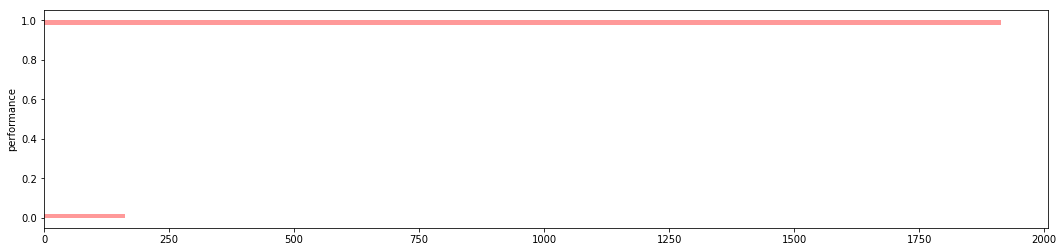

In [46]:
#Distribution performance
plt.figure(figsize=[18, 4])
sns.distplot(df_tw['performance'], kde=False, vertical=True, color="red")
print('Prediction Correct {} of {}'.format(df_tw['performance'].sum(), df_tw['performance'].count()))

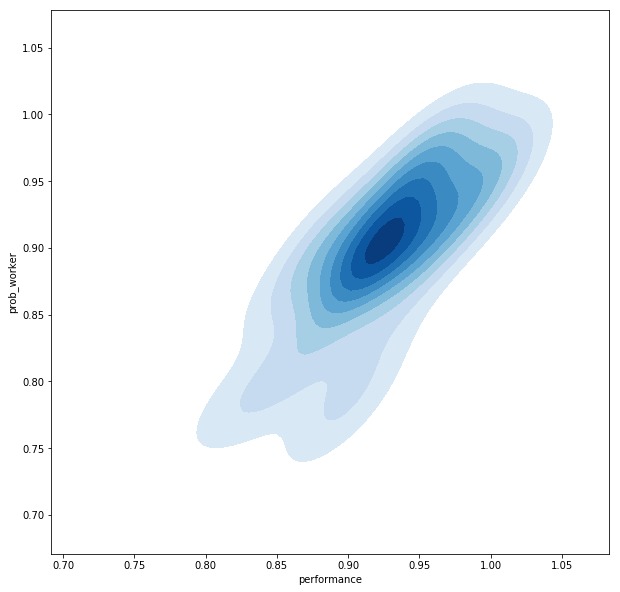

In [47]:
plt.figure(figsize=[10, 10])
sns.kdeplot(perf._workers()['performance'], perf._workers()['prob_worker'], cmap="Blues", shade=True, shade_lowest=False)

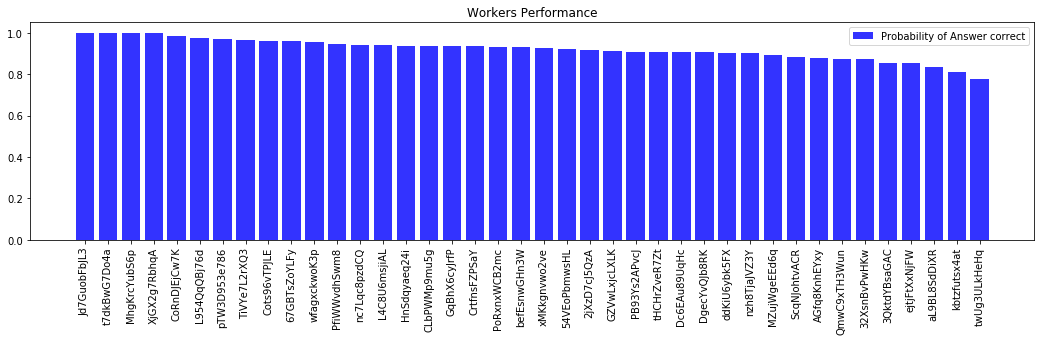

In [48]:
plt.figure(figsize=[18, 4])
axis = range(len(perf._workers()))
plt.bar(axis, perf._workers()['performance'], align='center', alpha=0.8, color='blue', label='Probability of Answer correct')
plt.xticks(axis, perf._workers()['worker_id'], rotation=90)
plt.title('Workers Performance')
plt.legend(loc='best')
plt.show()

In [49]:
perf._workers().describe()

,prob_task,prob_worker,performance,task_id
count,40.000000,40.000000,40.000000,40.000000
mean,0.540652,0.892749,0.920878,51.875000
std,0.036465,0.059548,0.051333,7.275486
min,0.418571,0.767366,0.775000,39.000000
25%,0.525649,0.861885,0.898214,47.000000
50%,0.536637,0.902979,0.928480,51.000000
75%,0.565952,0.932875,0.958281,55.250000
max,0.636596,0.981417,1.000000,67.000000


---
### Get Accuracy (Make Module)

In [50]:
import sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm
import make as mk

PTT = .3

def tasks_split(df, p=PTT):
    _train = df.sample(frac=p, random_state=23)
    _rest = df.loc[df.index.difference(_train.index)]
    return _train, _rest


def _update_progress(job_title, progress):
    length = 20
    block = int(round(length * progress))
    msg = "\r{0}: [{1}] {2}%".format(
        job_title, "#" * block + "-" * (length - block), round(progress * 100, 2))
    if progress >= 1:
        msg += " DONE\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

def crowd_table(total_tasks=100, total_workers=30, p_hard_tasks=0.4, ptt=.3, wpt=5, nk=5, a=28, b=3):
    #Defining the experiment parameters
    df_tasks = cs.Tasks(nk).create(total_tasks, p_hard_tasks)
    workers = cs.Workers(a,b).create(total_workers)
    keys = df_tasks['true_answers'].unique()
    tasks_train, tasks_rest = tasks_split(df_tasks, ptt)
    #Compute Method for Training set
    df_tw = cs.AssignTasks(tasks_train, workers, wpt).create()
    cp = cm.ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)
    df_tw['worker_answers'] = cm.WorkerAnswer(df_tw['true_answers'], cp.predict(), keys).match()
    df_tw['performance'] = cp.predict()
    #Select the good workers from training phase
    perf = cm.Performance(df_tw)
    trained_workers = perf.trained_workers()
    #Compute Method for the rest of the set
    df_tw_2 = cs.AssignTasks(tasks_rest, trained_workers, wpt).create()
    cp2 = cm.ComputeProbability(df_tw_2['prob_task'], df_tw_2['prob_worker'], keys)
    df_tw_2['worker_answers'] = cm.WorkerAnswer(df_tw_2['true_answers'], cp2.predict(), keys).match()
    df_tw_2['performance'] = cp2.predict()
    #Append two sets in one final set
    df = df_tw.append(df_tw_2)
    return df

def crowd_table_one_stage(total_tasks=100, total_workers=30, p_hard_tasks=0.4, ptt=.3, wpt=5, nk=5, a=28, b=3):
    #Defining the experiment parameters
    df_tasks = cs.Tasks(nk).create(total_tasks, p_hard_tasks)
    workers = cs.Workers(a,b).create(total_workers)
    keys = df_tasks['true_answers'].unique()
    #Compute Method
    df_tw = cs.AssignTasks(df_tasks, workers, wpt).create()
    cp = cm.ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)
    df_tw['worker_answers'] = cm.WorkerAnswer(df_tw['true_answers'], cp.predict(), keys).match()
    df_tw['performance'] = cp.predict()
    return df_tw

In [51]:
from pycm import *

In [52]:
df = crowd_table(total_tasks=415, total_workers=40, p_hard_tasks=0.4, ptt=0.3, wpt=5, nk=5, a=28, b=3)
cm2 = ConfusionMatrix(df['true_answers'].tolist(), df['worker_answers'].tolist())
cm2.matrix()
cm2.Overall_ACC

Predict          billet   charts   hooks    phase    wraps    
Actual
billet           403      3        1        3        5        
charts           4        360      2        3        1        
hooks            2        1        406      3        3        
phase            3        6        5        449      2        
wraps            2        5        1        7        395      



0.9701204819277108

In [53]:
df1 = crowd_table_one_stage(total_tasks=415, total_workers=40, p_hard_tasks=0.4, ptt=0.3, wpt=5, nk=5, a=28, b=3)
cm1 = ConfusionMatrix(df1['true_answers'].tolist(), df1['worker_answers'].tolist())
cm1.matrix()
cm1.Overall_ACC

Predict          complainthunt     idea     pain     problem  
Actual
complaint        352      5        2        3        3        
hunt             4        333      4        3        6        
idea             8        8        414      5        5        
pain             5        8        4        385      13       
problem          8        5        6        10       476      



0.944578313253012